## 언어 모델을 사용한 문장 생성
5,6에서는 RNN 과 LSTM 을 자세하게 살펴봤다.
이번 장에서는 LSTM을 이용할 것이다.

언어 모델을 사용해 문장 생성을 수행한다.
구처젝으로는 우선 말뭉치를 사용해 학습한 언어 모델을 이용하여 새로운 만장을 만들어낸다.
그런 다음 개선된 언어 모델을 이용하여 더 자연스러운 문장을 생성해보겠다.
여기까지 해보면 AI로 글을 쓰게 한다는 개념을 실감할 수 있을 것이다.

여기서 멈추지 않고 seq2seq 라는 새로운 구조의 신경망도 다룬다.
seq2seq 란, from seq to seq 를 뜻하는 말로, 한 시계열 데이터를 다른 시계열 데이터로 변환하는 걸 말한다.
이번 장에서는 RNN 두 개를 연결하는 아주 간단한 방법으로 seq2seq를 구현해볼 것이다.

이 seq2seq 는 기계 번역, 챗봇, 메일의 자동 답신 등 다양하게 응용될 수 있다.
이번 절에서는 언어 모델로 문장을 생성해보겠다.

## RNN 을 사용한 문장 생성의 순서
앞 장에서는 LSTM 계층을 이용하여 언어 모델을 구현했는데,
그 모델의 신경망 구성은 다음 그림처럼 생겼다.
그리고 시계열 데이터를 T개분 만큼 모아 처리하는 Time LSTM 과 Time Affine 계층 등을 만들었다.

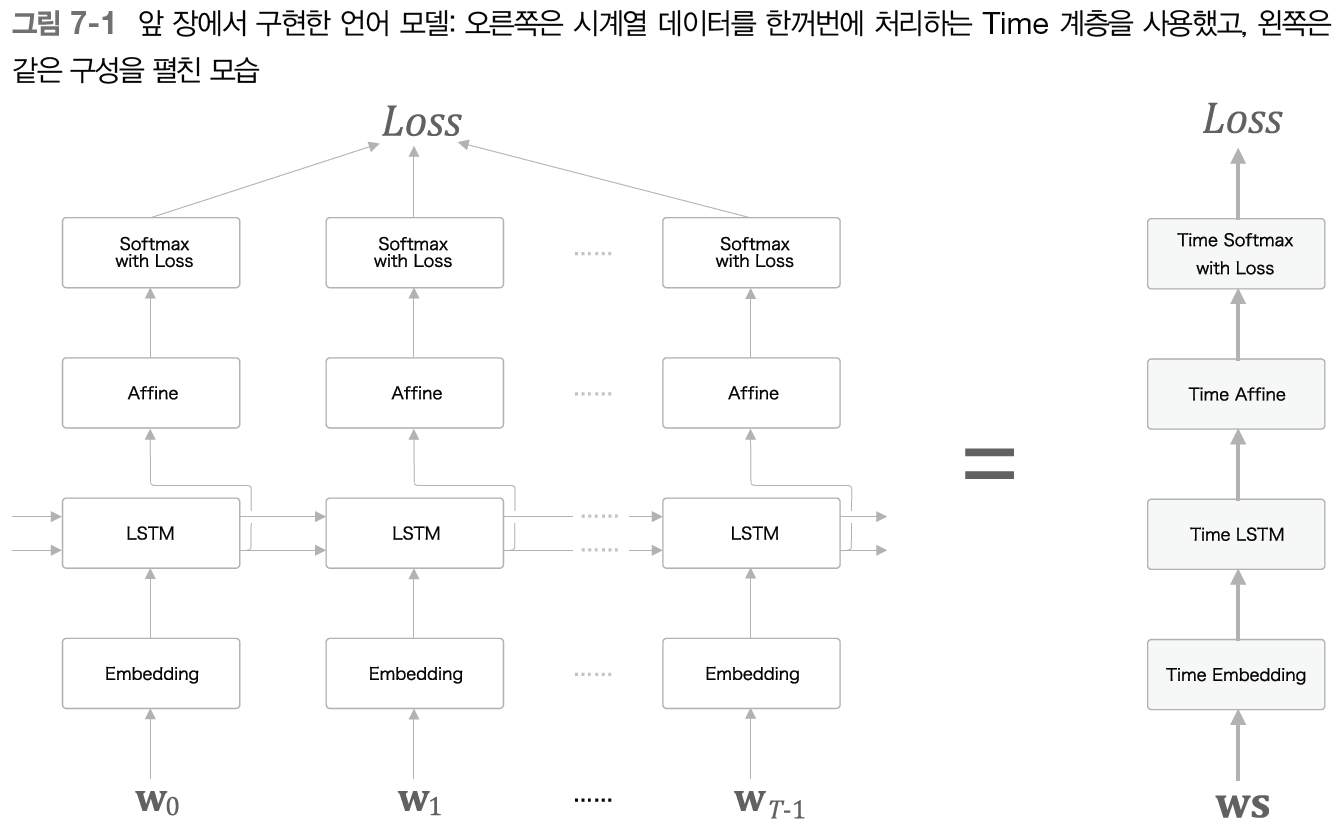

이제 언어 모델에게 문장을 생성시키는 순서를 설명하겠다.
이번에도 친숙한 "you say goodbye and I say hello"라는 말뭉치로 학습한 언어 모델을 예로 생각해보겠다.

이 학습된 언어 모델에 "I"라는 단어를 입력으로 주면 어떻게 될까?
그러면 이 언어 모델은 다음 그림과 같은 확률 분포를 출력한다고 한다.

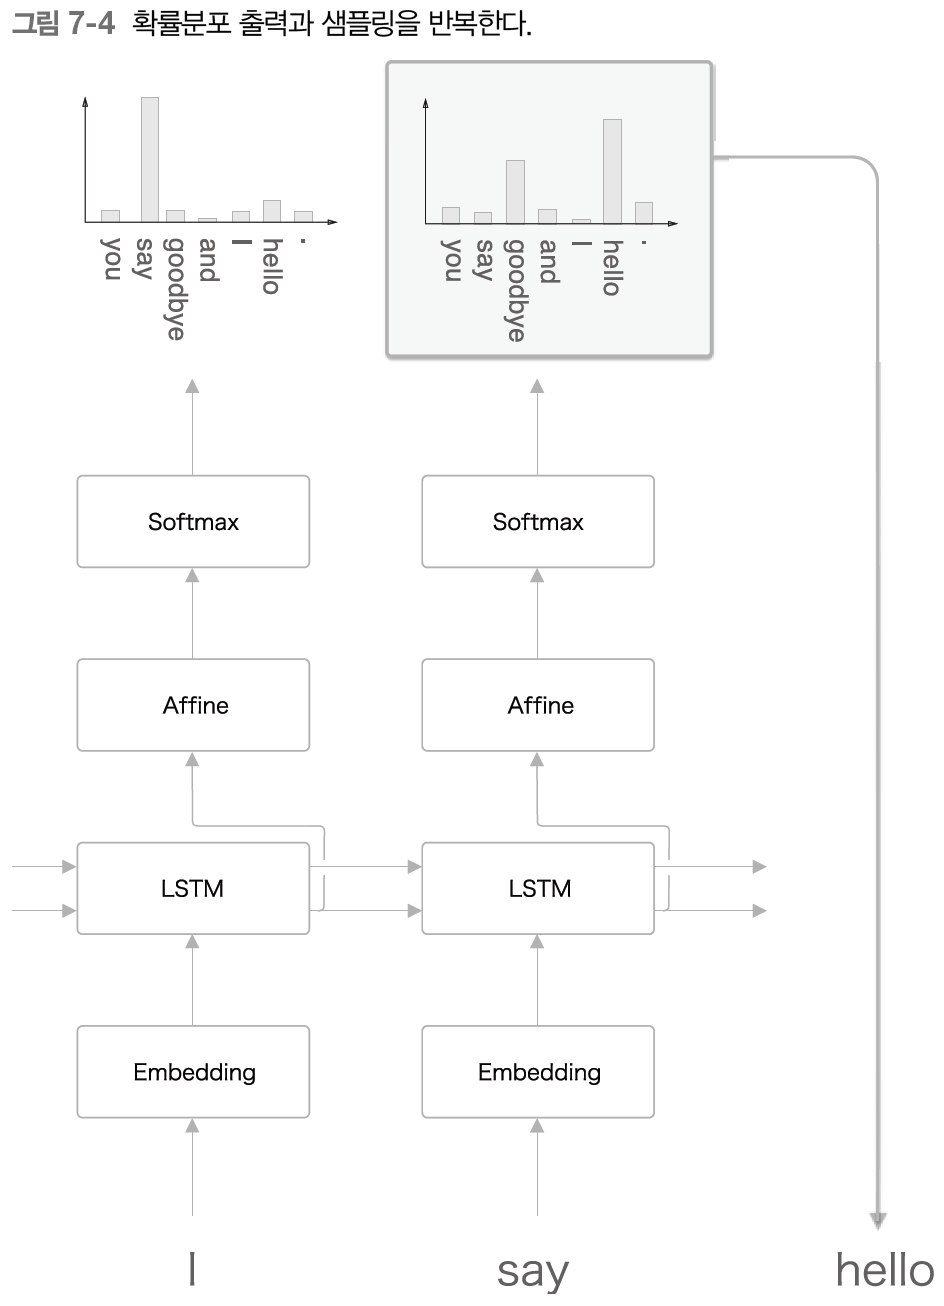

다음은 이 작업을 원하는 만큼 반복한다.
그러면 새로운 문장을 생성할 수 있다.

여기에서 주목할 것은 이렇게 생성한 문장은 훈련 데이터에는 존재하지 않는, 말 그대로 새로운 생성된 문장이라는 것이다.
왜냐하면 언어 모델은 훈련 데이터를 암기한 것이 아니라, 훈련 데이터에서 사용된 단어의 정렬 패턴을 학습한 것이기 때문이다.
만약 언어 모델이 말뭉치로부터 단어의 출현 패턴을 올바르게 학습할 수 있다면, 그 모델이 새로 생성하는 문장은 우리 인간에게도 자연스럽고 의미가 통하는 문장일 것으로 기대할 수 있다.

## 문장 생성 구현

In [13]:
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


In [14]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


In [5]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        '''
        주어진 start_id로부터 단어 ID 시퀀스를 생성합니다.

        매개변수:
        - start_id (int): 생성을 시작할 단어 ID입니다.
        - skip_ids (list 또는 None): 생성 중 건너뛸 단어 ID 목록입니다. 건너뛰지 않을 경우 None입니다.
        - sample_size (int): 생성할 총 단어 수입니다.

        반환값:
        - list: 생성된 단어 ID 시퀀스입니다.
        '''
        word_ids = [start_id]  # 시작 단어 ID로 초기화

        x = start_id  # 시작 단어 ID로 x를 초기화
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)  # 예측을 위해 x를 형태 변환합니다.
            score = self.predict(x)  # 다음 단어 점수를 예측합니다.
            p = softmax(score.flatten())  # 확률을 얻기 위해 softmax를 적용합니다.

            sampled = np.random.choice(len(p), size=1, p=p)  # 확률 분포에서 샘플링합니다.
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled  # 샘플링된 단어 ID로 x를 업데이트합니다.
                word_ids.append(int(x))  # 샘플링된 단어 ID를 word_ids에 추가합니다.

        return word_ids

    def get_state(self):
        '''
        LSTM 계층의 현재 상태를 반환합니다.

        반환값:
        - tuple: LSTM 계층의 현재 은닉 상태 (h)와 셀 상태 (c).
        '''
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        '''
        LSTM 계층의 상태를 설정합니다.

        매개변수:
        - state (tuple): 설정할 LSTM 계층의 은닉 상태 (h)와 셀 상태 (c).
        '''
        self.lstm_layer.set_state(*state)


In [6]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [9]:
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]

np.array(start_id).reshape(1, 1)

array([[316]])

In [10]:
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)


you subscribe more ways to go out of clients through indianapolis to illustration military kangyo laws on level cancer insurance companies.
 this may be able to report reasonable terms and they use to finish that way will not fall be on how much despite no unexpected buying the bread of liquidity.
 bribe mr. kemp might identify the leg of dead an addition to engaging down the culture.
 david lavelle who turned syndrome graphics notes.
 about # a week 's two-year security california deficit.
 in addition salomon inc. a edition of lyondell lowered its third-quarter profit


C:\Users\hopio\AppData\Local\Temp\ipykernel_665888\791050925.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))  # 샘플링된 단어 ID를 word_ids에 추가합니다.


In [6]:
from common.np import *

from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params(file_name='BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

C:\Users\hopio\AppData\Local\Temp\ipykernel_565968\4123625672.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  word_ids.append(int(x))


you do n't know how to happen.
 people in the lighter are beginning to still say the disorders are not a reason for business and we 're pumped to feel work says mr. jones.
 jack rosenthal was another senior vice president at the brokerage firm as attending his general counsel mrs. aquino for the sale of the government to propose the new company 's.
 there were a lot of the fans here he says.
 when a telecommunications spokeswoman allowed you to be here in the hands of the can we suspected had refuge it.
 of
--------------------------------------------------
the meaning of life is it often is available and it will help detect an growing money in any government that did do n't the road.
 this formal deal of business the life station is financed by the justice department for vietnamese and parents who in spouse must qualify for creative topics for human names he said.
 no one gets much more important than the we 've known.
 by michigan state judge robert r. sullivan of webster 's commissi

## seq2seq 모델

시계열 데이터는 매우 다양합니다. 언어 데이터, 음성 데이터, 동영상 데이터 모두 시계열 데이터에 속하며, 이를 다른 시계열 데이터로 변환하는 문제는 매우 중요합니다. 예를 들어 기계 번역, 음성 인식, 대화형 애플리케이션 등 다양한 응용 분야에서 사용됩니다.

seq2seq 모델은 Encoder-Decoder 구조를 기반으로 시계열 데이터를 변환하는 방법입니다.

### 구조 개요

seq2seq 모델은 크게 두 부분으로 나뉘어집니다:

- **Encoder**: 입력 시계열 데이터를 인코딩하여 정보를 압축합니다.
- **Decoder**: 인코딩된 정보를 디코딩하여 원하는 출력 시계열 데이터를 생성합니다.

이 구조를 이해하는 한 가지 예시로는 한국어를 영어로 번역하는 과정을 살펴볼 수 있습니다.

### 예시: 한국어를 영어로 번역하는 과정

**입력 문장 (한국어)**: "나는 고양이로소이다"

**목표 출력 문장 (영어)**: "I am a cat"

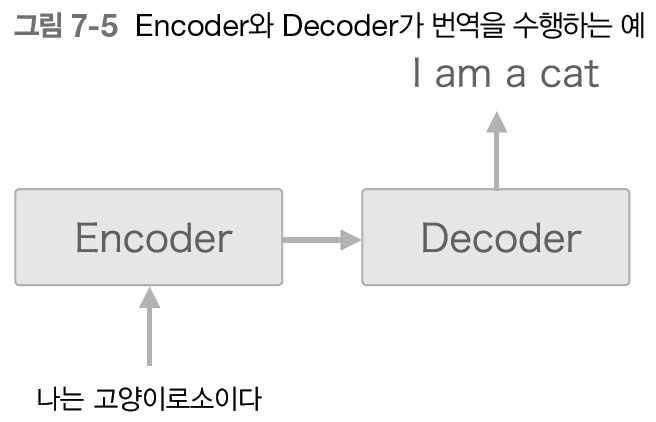

#### 구체적인 과정

1. **Encoder**
   - "나는 고양이로소이다" 문장을 단어 단위로 분할하고 각 단어를 임베딩하여 순차적으로 처리합니다.
   - LSTM 레이어를 통해 각 시간 단계에서의 은닉 상태를 계산하고, 최종 은닉 상태를 얻습니다.

2. **Decoder**
   - Encoder에서 얻은 최종 은닉 상태를 초기 상태로 설정하여 번역 문장을 생성합니다.
   - 시작 토큰 `<sos>`를 입력으로 설정하고, LSTM 레이어를 통해 각 시간 단계에서의 출력을 계산합니다.
   - 다음 시간 단계의 입력으로는 이전 시간 단계의 출력을 사용합니다.
   - `<eos>` 토큰을 생성할 때까지 반복적으로 단어를 예측합니다.

이 과정을 통해 Encoder와 Decoder가 협력하여 시계열 데이터를 변환하는 seq2seq 모델의 작동 방식을 이해할 수 있습니다.


## Encoder

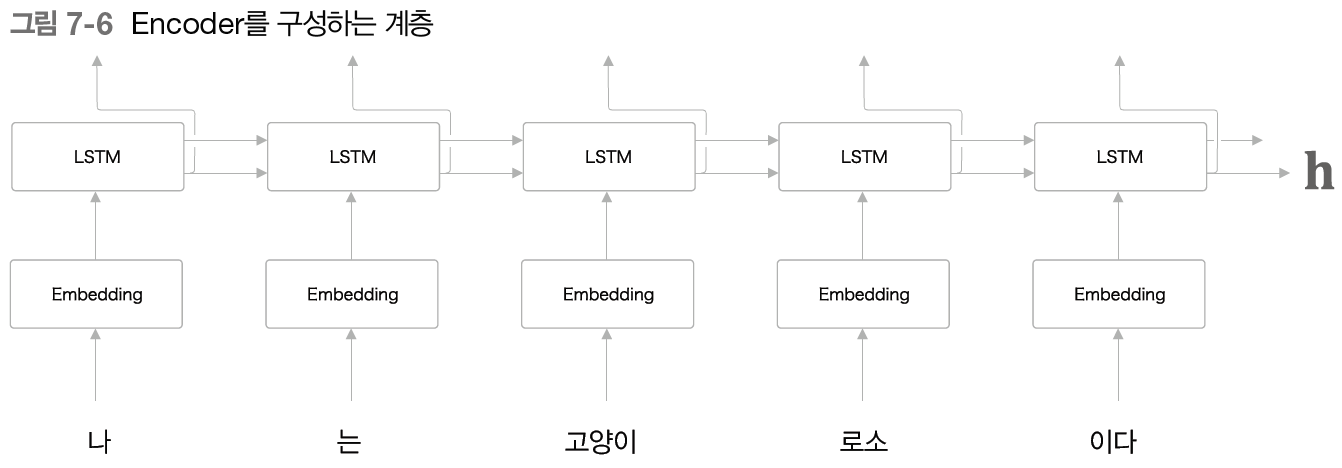

그런데 그림에서 Encoder 가 출력하는 벡터 h는 LSTM 계층의 마지막 은닉 상태이다.
이 마지막 은닉 상태 h에 입력 문장(출발어)를 번역하는 데 필요한 정보가 인코딩된다.
여기서 중요한 점은 LSTM의 은닉 상태 h는 고정 길이 벡터라는 사실이다.
그래서 인코딩한다라 함은, 결국 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 된다.

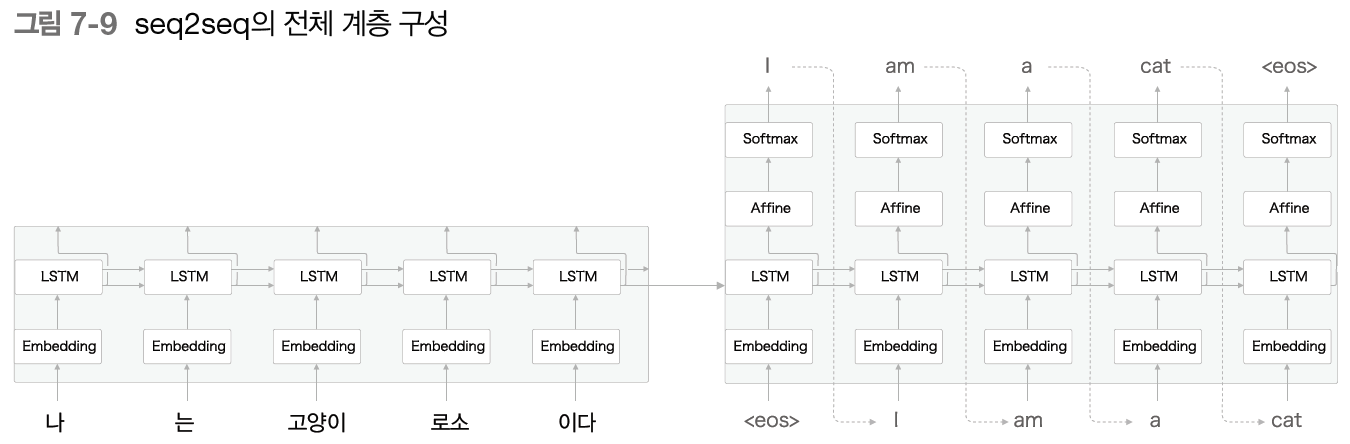

그럼다면 Decoder 는 이 인코딩된 벡터를 어떻게 요리하여 도착어 문장을 생성하는 것일까?
앞 절에서 다룬 문장 생성 모델을 그대로 이용할 수 있다.

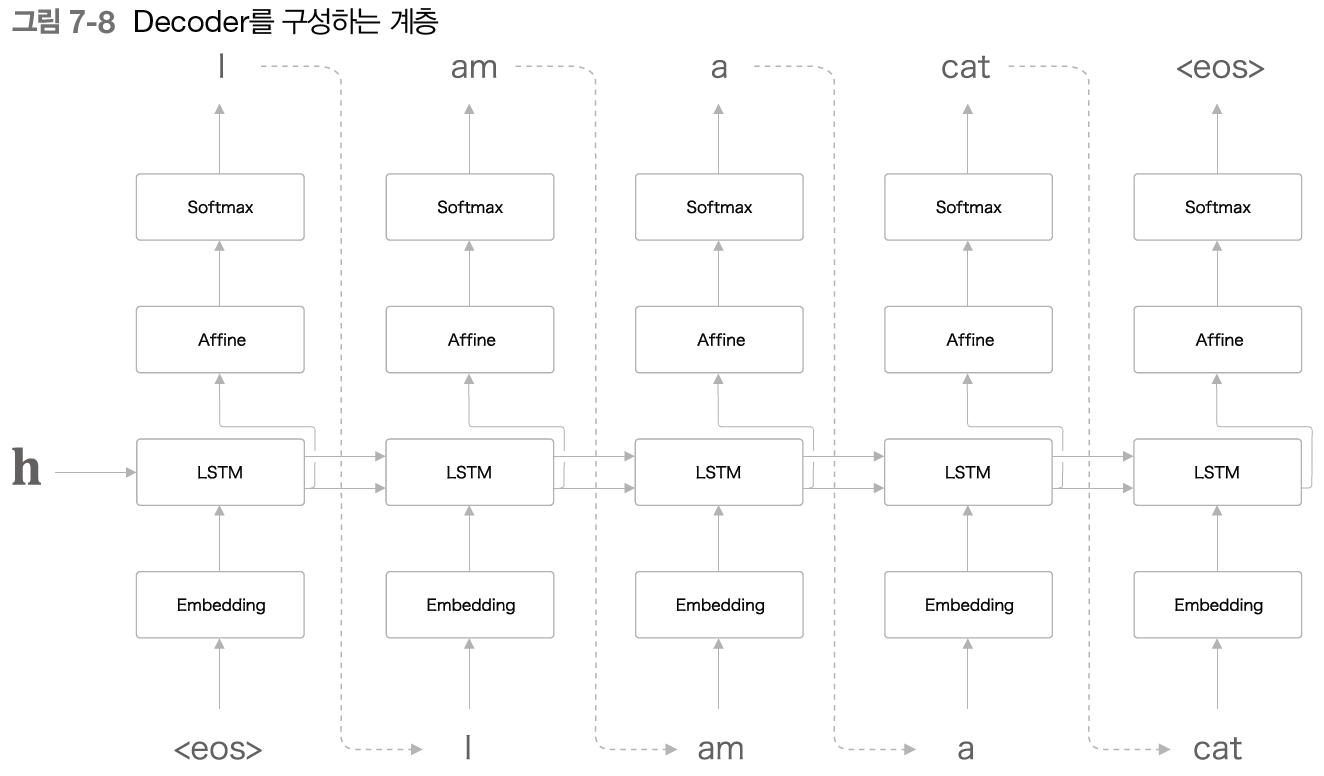

그림과 같이 Decoder 는 앞 절의 신경망과 완전히 같은 구성이다.
단 한가지, LSTM 계층이 벡터 h를 입력받는다는 점이 다르다.
참고로, 앞 절의 언어 모델에서는 LSTM 계층이 아무것도 받지 않ㄴ다. (굳이 따지자면, 은닉 상태로 영벡터를 받았다고 할 수 있다)
이처럼 단 하나의 사소한 차이가 평범한 언어 모델을 번역도 해낼 수 있는 Decoder 로 탈바꿈시킨다.

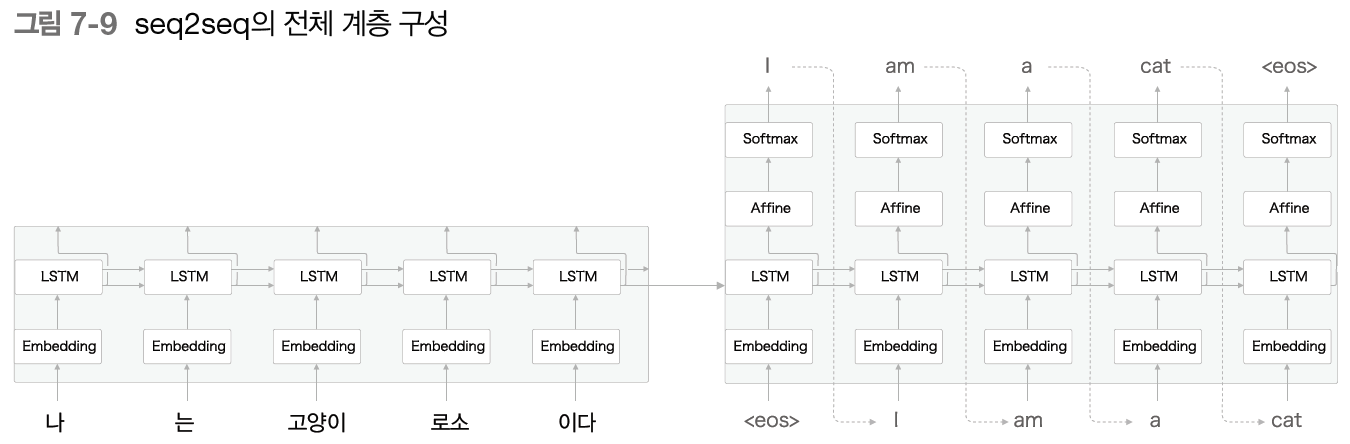

seq2seq 는 LSTM 두 개로 구성된다.
(Encoder 의 LSTM, Decoder 의 LSTM)
이때 LSTM 계층의 은닉 상태가 Encoder 와 Decoder 를 이어주는 가교가 된다.
순전파 때는 Encoder 에서 인코딩된 정보가 LSTM 계층의 은닉 상태를 통해 Decoder 에 전해진다.
그리고 seq2seq 의 역전파 때는 이 가교를 통해 기울기가 Decoder 로부터 Encoder 로 전해진다.

## 시계열 데이터 변환용 장난감 문제
지금부터, 다룰 문제에 관해 설명하겠다.
우리는 시계열 변환 문제의 예로 더하기를 다루었다.
구체적으로는 57+5와 같은 문자열을 seq2seq 에 건네면 62라는 정답을 내놓도록 학습시킬 것이다.
참고로 이와 같이 머신러닝을 평가하고자 만든 간단한 문제를 장난감 문제라고 한다.

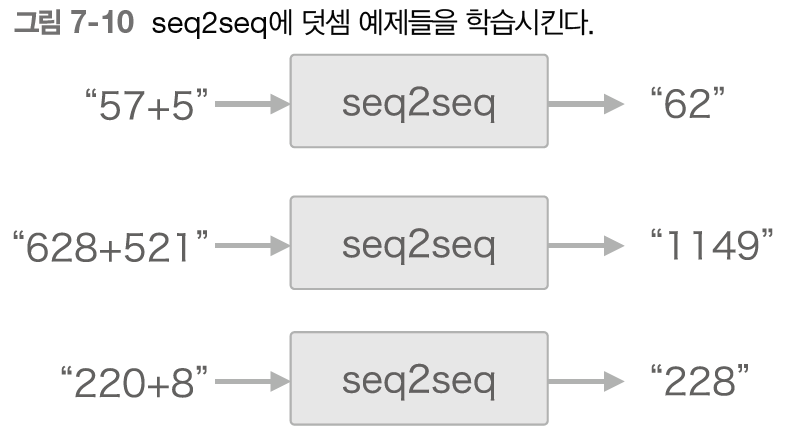

덧셈은 우리 인간에게는 쉬운 문제이다.
그러나 seq2seq 는 덧셈에 대해 (정확하게 덧셈의 논리에 대해) 아무것도 모른다.
seq2seq 는 덧셈의 샘플로부터 거기서 사용되는 문자의 패턴을 학습한다.
과연 이런 식으로 해서 덧셈의 규칙을 올바르게 학습할 수 있는걸까?

우리는 지금까지 word2vec 이나 언어 모델 등에서 문자을 단어 단위로 분할해왔다.
하지만 문장을 반드시 단어로 분할해야 하는 건 아니다.
실제로 이번 문제에서는 단어가 아닌 문자 단위로 분할한다.
문자 단위 분할이란, 예컨대 57+5 가 입력되면, [5,7,+,5] 라는 리스트로 처리하는 걸 말한다.

## 가변 길이 시계열 데이터
우리는 덧셈을 문자 리스트로써 다루기로 했다.
이때 주의할 점은 덧셈 문장(5,7,+,5)이나 그 대답의 문자 수(6,2)가 문제마다 다르다는 것이다.

이러첨 이번 덧셈 문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다.
가변 길이 시계열 데이터를 다룬다는 뜻이다.
따라서 신경망 학습 시 미니배치 처리를 하려면 무언가 추가 노력이 필요하다.

미니배치로 학습할 때는 다수의 샘플을 한꺼번에 처리한다.
이때 한 미니배치에 속한 샘플들의 데이터 형상이 모두 똑같아야 한다.

가별 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩을 사용하는 것이다.
패딩이란 원리의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법이다.

다음 그림은 패딩을 이번 덧셈 문제에 적용해본 모습이다.
모든 입력 데이터의 길이를 통일하고, 남는 공간에는 의미 없는 데이터(여기서는 공백)을 채웠다.
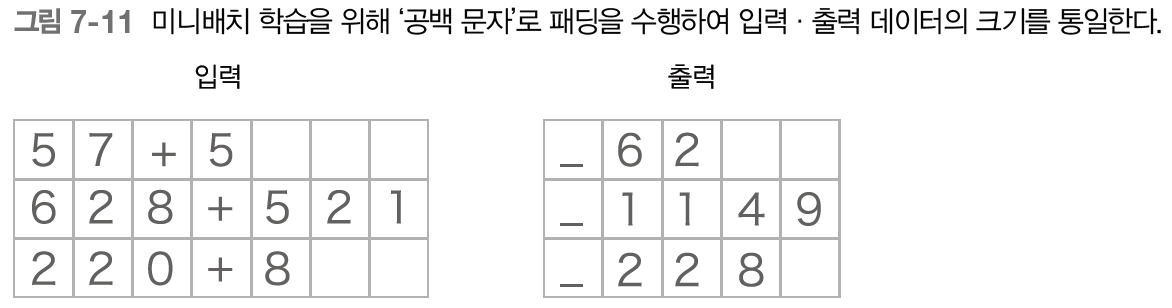

이번 문제에서는 0~999 사이의 숫자 2개만 더하기로 하겠다.
따라서 +까지 포함하면 입력의 최대 문자 수는 7,
자연스럽게 덧셈 결과는 최대 4문자이다.

더불어 정답 데이터에도 패딩을 수행해 모든 샘플 데이터의 길이를 통일한다.
그리고 질문과 정답을 구분하기 위해 출력 앞에 구분자로 _를 붙이기로 한다.
그 결과 출력 데이터는 총 5문자로 통일한다.
참고로, 이 구분자는 Decoder 에 문자열을 생성하라고 알리는 신호로 사용된다. (?)

이처럼 패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시걔열 데이터도 처리할 수 있다.
그러나 원리는 존재하지 않던 패딩용 문자까지 seq2seq 가 처리하게 된다.
따라서 패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq 에 패딩 전용 처리를 추가해야 한다.

예컨대 Decoder 에 입력된 데이터가 패딩이라면 손실의 결과에 반영하지 않도록 해야 한다.
Softmax with Loss 계층에 마스크 기능을 추가해 해결할 수 있다.

한편 Encoder 에 입력된 데이터가 패딩이라면 LSTM 계층이 이전 시각의 입력을 그대로 출력하게 한다.
즉, LSTM 계층은 마치 처음부터 패딩이 존재하지 않았던 것처럼 인코딩할 수 있다.

이번 장에서는 이해 난이도를 낮추기 위해 패딩용 문자(공백 문자)도 특별히 구분하지 않고 일반 데이터처럼 다루겠다.

## 덧셈 데이터셋

지금부터 사용할 덧셈 학습 데이터는 예제 총 5000개가 들어 있고, 다음 그리과 같은 형태이다.
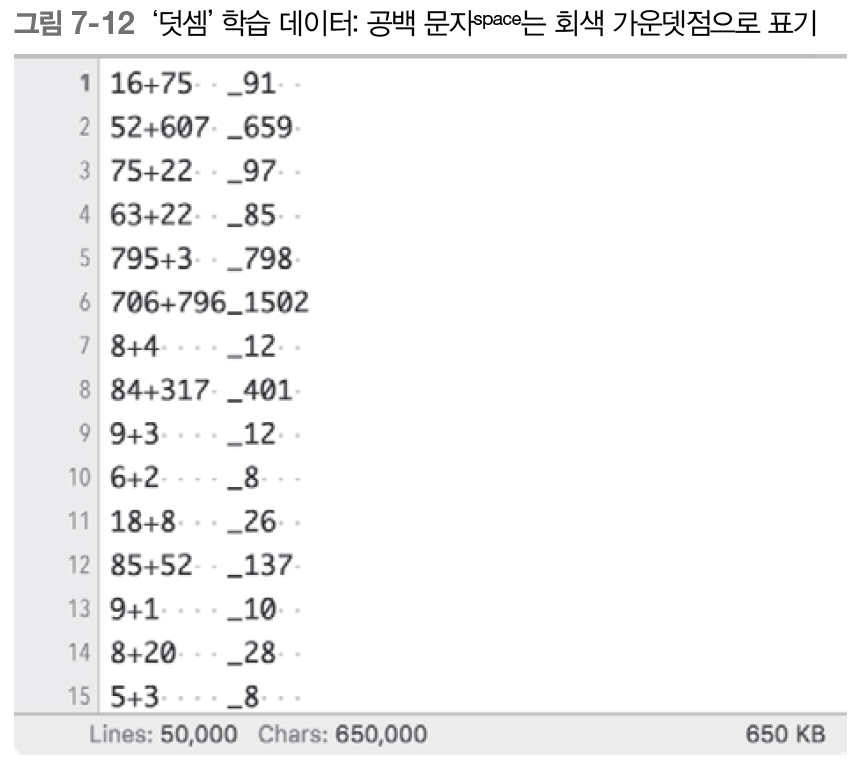

In [11]:
import sys
sys.path.append('..')
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## seq2seq 구현

seq2seq 는 두 개의 RNN을 연결한 신경망이다.
먼저 두 RNN을 Encoder 클래스와 Decoder 클래스로 각각 구현하겠다.
그런 다음 두 클래스를 연결하는 Seq2seq 클래스를 구현하는 흐름으로 진행한다.

## Encoder 클래스
Encoder 클래스는 다음 그림처럼 문자열을 받아 벡터 h로 변환한다.
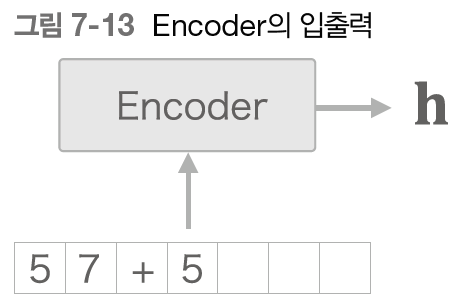
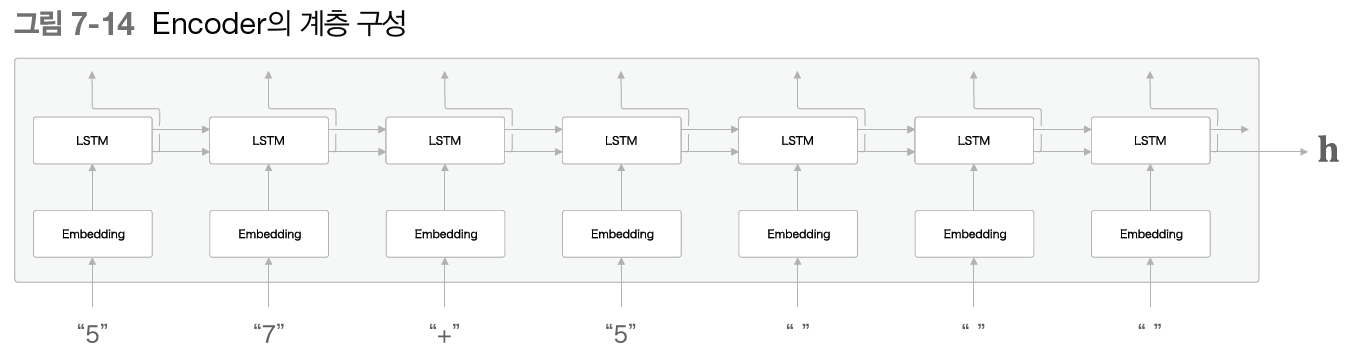

Encoder 클래스는 Embedding 계층과 LSTM 계층으로 구성된다.
Embedding 계층에서는 문자 ID를 문자 벡터로 변환한다.
그리고 이 문자 벡터가 LSTM 계층으로 입력된다.
LSTM 계층은 시간 방향(오른쪽)으로 은닉 상태와 셀을 출력하고
위쪽으로는 은닉 상태만 출력한다.
이 구성에서 더 위에는 다른 계층이 없으니 LSTM 계층의 위쪽 출력은 폐기된다.
Encoder 에서는 마지막 문자를 처리한 후 LSTM 계층이 은닉 상태 h를 출력한다.
그리고 이 은닉 상태 h가 Decoder 로 전달된다.
Encoder 에서는 LSTM 의 은닉 상태만을 Decoder 에 전달한다.
LSTM의 셀도 Decoder 에 전달할 수는 있지만, LSTM 의 셀을 다른 계층에 전달하는 일은 일반적으로 흔치 않다.
LSTM 의 셀은 자기 자신만 사용한다는 전제로 설계되었기 때문이다.

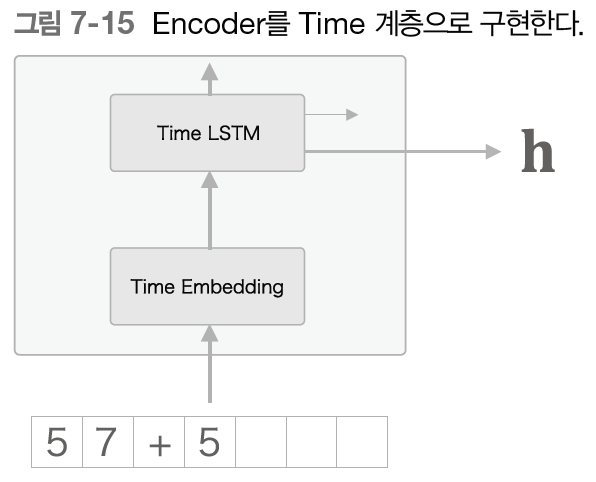

In [12]:
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        Encoder 클래스는 입력 시퀀스를 받아 인코딩하는 역할을 합니다.

        Parameters:
        - vocab_size (int): 어휘 사전의 크기, 즉 단어 집합의 크기입니다.
        - wordvec_size (int): 단어 벡터의 차원 크기입니다.
        - hidden_size (int): LSTM 계층의 은닉 상태의 차원 크기입니다.

        Attributes:
        - embed (TimeEmbedding): 시간 축을 고려한 Embedding 레이어 객체입니다.
        - lstm (TimeLSTM): 시간 축을 고려한 LSTM 레이어 객체입니다.
        - params (list): Encoder에 속하는 모든 레이어의 매개변수 리스트입니다.
        - grads (list): Encoder에 속하는 모든 레이어의 기울기 리스트입니다.
        - hs (ndarray): Encoder의 LSTM 레이어의 마지막 은닉 상태입니다.

        Initialization:
        - embed_W: 임베딩 가중치 행렬입니다.
        - lstm_Wx: LSTM 입력 가중치 행렬입니다.
        - lstm_Wh: LSTM 은닉 상태 가중치 행렬입니다.
        - lstm_b: LSTM의 편향 벡터입니다.
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        """
        Encoder의 순전파 메서드입니다.

        Parameters:
        - xs (ndarray): 입력 시퀀스 데이터입니다. 각 원소는 단어 ID로 구성된 시퀀스입니다.

        Returns:
        - ndarray: Encoder의 LSTM 레이어의 마지막 은닉 상태를 반환합니다.
        """
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        """
        Encoder의 역전파 메서드입니다.

        Parameters:
        - dh (ndarray): 상위 층에서 전달된 기울기입니다. Decoder의 기울기가 전달됩니다.

        Returns:
        - ndarray: Encoder의 역전파 결과 기울기입니다.
        """
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


## Decoder 클래스

Decoder 클래스는 Encoder 클래스가 출력한 h를 받아 목적으로 하는 다른 문자열을 출력한다.
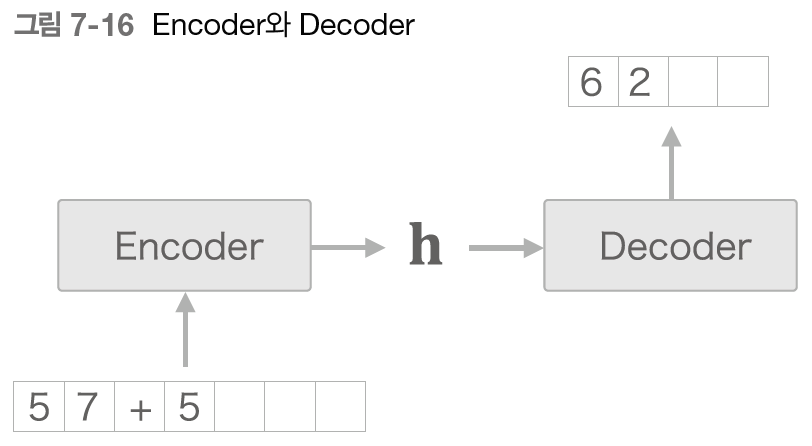

Decoder 는 RNN으로 구현할 수 있다.
Encoder 와 마찬가지로 LSTM 계층을 사용하면 되며, 이때 Decoder 의 계층 구선은 다음 그림과 같다.

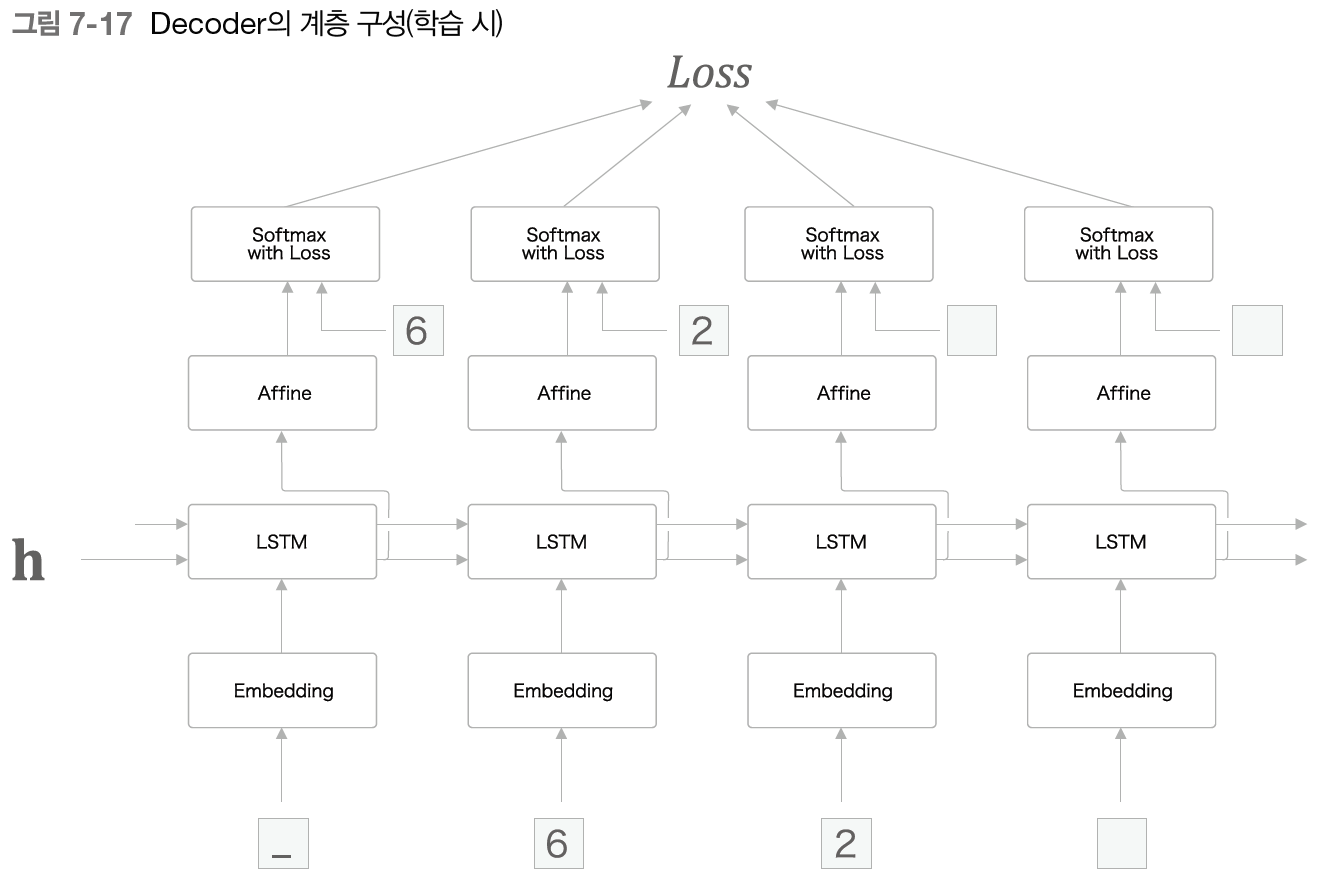

## 문장 생성 과정

RNN으로 문장을 생성할 때, 학습 시와 생성 시의 데이터 부여 방법이 다릅니다. 

### 학습 시 데이터 부여 방법
- 학습 시에는 정답을 알고 있기 때문에 시계열 방향의 데이터를 한꺼번에 보여줄 수 있습니다.

### 추론 시 데이터 부여 방법
- 추론 시(새로운 문자열을 생성할 때)에는 최초 시작을 알리는 구분 문자(여기서는 `_`) 하나만 제공합니다.
- 이후 출력으로부터 문자를 하나 샘플링하여, 그 샘플링 문자를 다음 입력으로 사용하는 과정을 반복합니다.

### 결정적인 답 생성
- 뎃셈 문제와 같이 확률적인 비결정성을 배제하고 결정적인 답을 생성하려면, 점수가 가장 높은 문자 하나만 선택합니다.

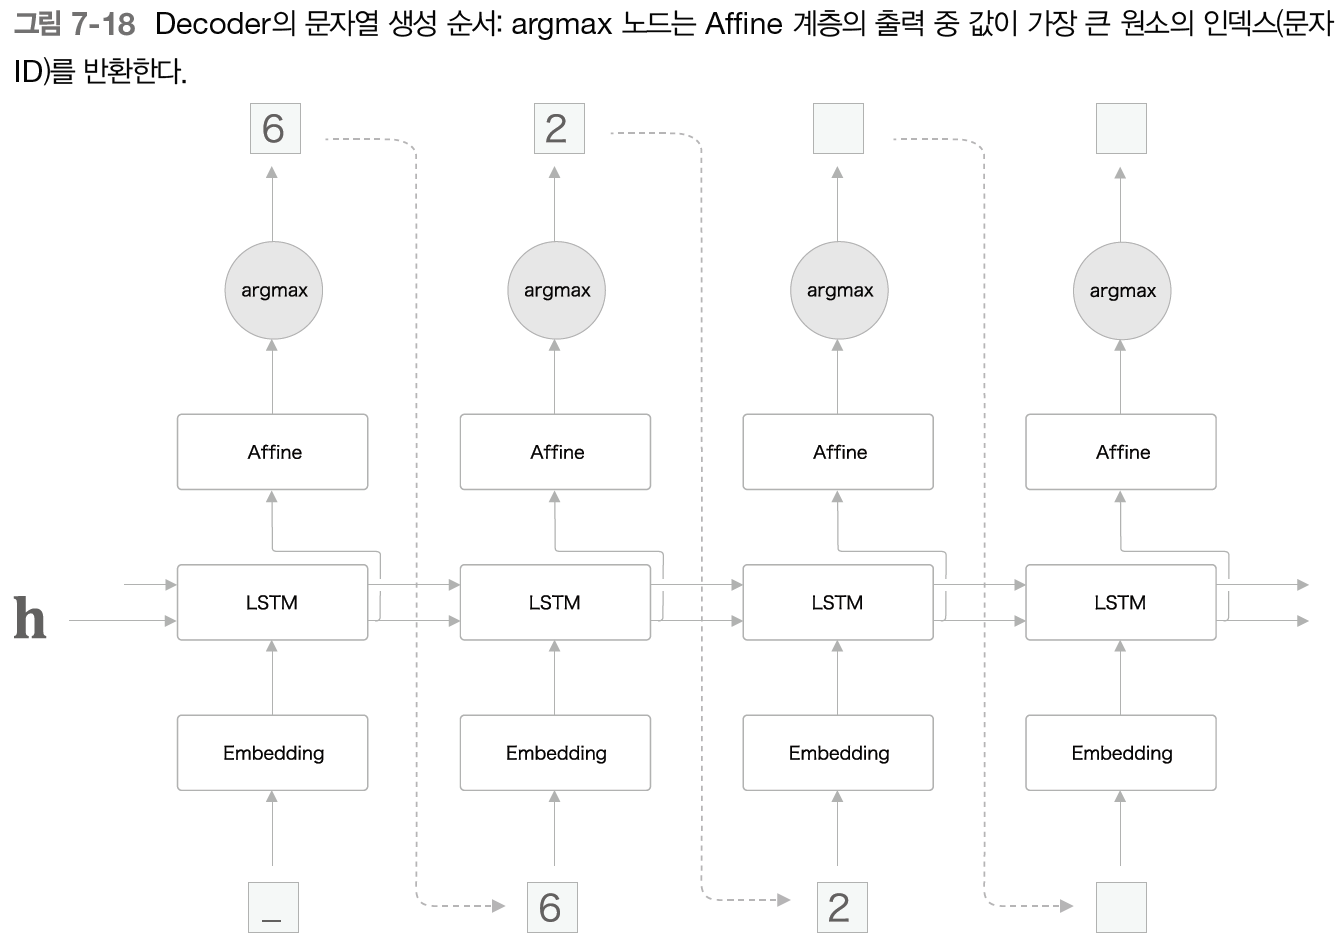
## Softmax 계층과 argmax 노드

Softmax 계층은 입력된 벡터를 정규화하는 역할을 합니다. 이 정규화 과정에서 각 원소의 값은 변하지만 대소 관계는 유지됩니다. 따라서 Softmax 계층을 통과한 후의 벡터에서는 각 원소가 확률처럼 해석될 수 있습니다.

반면, argmax 노드는 주어진 벡터에서 최댓값을 가진 원소의 인덱스를 선택하는 노드입니다. 이는 단순히 가장 높은 점수를 가진 문자의 ID를 선택하는 것을 의미합니다.

### Softmax 계층의 생략

Softmax 계층은 입력 벡터의 정규화를 수행하지만, 대소 관계가 변하지 않기 때문에 일부 경우에서는 생략할 수 있습니다. 예를 들어, Decoder에서는 학습 시와 생성 시에 Softmax 계층을 다르게 다룹니다.

### Decoder의 Softmax 처리

Decoder에서는 학습 시에는 Softmax 계층을 사용하여 출력을 확률 분포로 변환합니다. 이를 통해 손실 함수를 계산하고, 역전파를 통해 학습을 진행합니다. 반면, 생성 시에는 argmax 노드를 사용하여 점수가 가장 큰 문자 ID를 선택하여 다음 입력으로 사용합니다.

### 다음 단계

Softmax with Loss 계층은 이후에 구현할 Seq2seq 클래스에서 처리하도록 하겠습니다. Decoder 클래스는 Time Softmax with Loss 계층 이전까지의 단계까지만을 담당할 계획입니다.


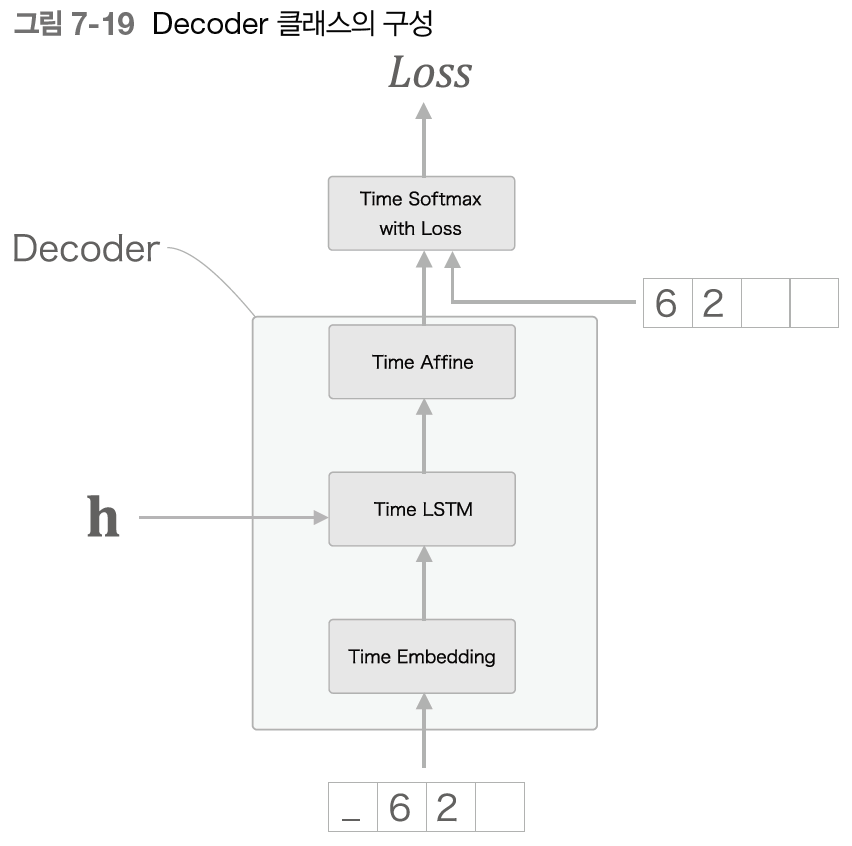

In [15]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        Decoder 클래스 초기화
        
        Args:
        - vocab_size (int): 어휘 사전 크기
        - wordvec_size (int): 단어 벡터의 차원 수
        - hidden_size (int): LSTM 계층의 은닉 상태의 차원 수
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 각 계층의 초기 가중치 설정
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 각 계층 초기화
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        # 모든 매개변수와 기울기 초기화
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        """
        순전파 메서드
        
        Args:
        - xs (numpy.ndarray): 입력 데이터의 미니배치
        - h (numpy.ndarray): LSTM 계층의 초기 은닉 상태
        
        Returns:
        - score (numpy.ndarray): 각 시점의 출력 점수
        """
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        """
        역전파 메서드
        
        Args:
        - dscore (numpy.ndarray): 출력에 대한 기울기
        
        Returns:
        - dh (numpy.ndarray): LSTM 계층의 은닉 상태에 대한 기울기
        """
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        """
        문자열 생성 메서드
        
        Args:
        - h (numpy.ndarray): 초기 LSTM 계층의 은닉 상태
        - start_id (int): 시작 문자의 ID
        - sample_size (int): 생성할 문자열의 길이
        
        Returns:
        - sampled (list): 생성된 문자열의 ID 리스트
        """
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled




In [ ]:
# Decoder 클래스 사용 예시
# decoder = Decoder(vocab_size, wordvec_size, hidden_size)
# h = np.zeros((1, hidden_size))  # 초기 은닉 상태 설정
# start_id = word_to_id['_']  # 시작 문자 '_'
# sample_size = 10  # 생성할 문자열의 길이
# sampled = decoder.generate(h, start_id, sample_size)
# generated_string = ''.join([id_to_word[idx] for idx in sampled])
# print(generated_string)

## Seq2seq 클래스

In [16]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        Seq2seq 모델 초기화
        
        Args:
        - vocab_size (int): 어휘 사전 크기
        - wordvec_size (int): 단어 벡터의 차원 수
        - hidden_size (int): LSTM 계층의 은닉 상태의 차원 수
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)  # 인코더 초기화
        self.decoder = Decoder(V, D, H)  # 디코더 초기화
        self.softmax = TimeSoftmaxWithLoss()  # 손실 계층 초기화

        # 모델의 모든 매개변수와 기울기를 결합
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        """
        순전파 메서드
        
        Args:
        - xs (numpy.ndarray): 인코더 입력 데이터
        - ts (numpy.ndarray): 디코더의 정답 데이터
        
        Returns:
        - loss (float): 계산된 손실 값
        """
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]  # 디코더 입력과 정답 준비

        h = self.encoder.forward(xs)  # 인코더 순전파
        score = self.decoder.forward(decoder_xs, h)  # 디코더 순전파
        loss = self.softmax.forward(score, decoder_ts)  # 손실 계산
        return loss

    def backward(self, dout=1):
        """
        역전파 메서드
        
        Args:
        - dout (float): 손실 기울기 (기본값: 1)
        
        Returns:
        - dout (numpy.ndarray): 인코더의 입력에 대한 기울기
        """
        dout = self.softmax.backward(dout)  # 손실 계층의 역전파
        dh = self.decoder.backward(dout)  # 디코더의 역전파
        dout = self.encoder.backward(dh)  # 인코더의 역전파
        return dout

    def generate(self, xs, start_id, sample_size):
        """
        문자열 생성 메서드
        
        Args:
        - xs (numpy.ndarray): 인코더 입력 데이터
        - start_id (int): 시작 문자의 ID
        - sample_size (int): 생성할 문자열의 길이
        
        Returns:
        - sampled (list): 생성된 문자열의 ID 리스트
        """
        h = self.encoder.forward(xs)  # 인코더 순전파
        sampled = self.decoder.generate(h, start_id, sample_size)  # 문자열 생성
        return sampled

# Seq2seq 클래스 사용 예시
# seq2seq_model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# loss = seq2seq_model.forward(input_data, target_data)  # 순전파 호출
# seq2seq_model.backward()  # 역전파 호출
# generated_ids = seq2seq_model.generate(input_data, start_id, sample_size)  # 문자열 생성
# generated_string = ''.join([id_to_word[idx] for idx in generated_ids])
# print(generated_string)


## seq2seq 평가
seq2seq 의 학습은 기본적인 신경망의 학습과 같은 흐름으로 이뤄진다.
1. 학습 데이터에서 미니배치를 선택하고
2. 매니배치로부터 기울기를 선택하고
3. 기울기를 사용하여 매개변수를 갱신한다.

Tainer 클래스를 사용해 이 규칙대로 작업을 수행한다.
매 애폭마다 seq2seq 가 테스트 데이터를 풀게 하여(문자열을 생성하여) 학습 중간중간 정답률을 측정한다.

다음은 seq2seq 학습 코드이다.

In [17]:
import sys
sys.path.append('..')
from common.time_layers import *

class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        PeekyDecoder 초기화
        
        Args:
        - vocab_size (int): 어휘 사전 크기
        - wordvec_size (int): 단어 벡터의 차원 수
        - hidden_size (int): LSTM 은닉 상태의 차원 수
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 초기화
        embed_W = (rn(V, D) / 100).astype('f')  # 임베딩 가중치
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')  # LSTM 입력 가중치
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')  # LSTM 은닉 상태 가중치
        lstm_b = np.zeros(4 * H).astype('f')  # LSTM 편향
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')  # Affine 계층 가중치
        affine_b = np.zeros(V).astype('f')  # Affine 계층 편향

        # 각 계층 초기화
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        # 매개변수 및 기울기 저장
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None  # 캐시 초기화

    def forward(self, xs, h):
        """
        순전파 메서드
        
        Args:
        - xs (numpy.ndarray): 입력 데이터 (시퀀스)
        - h (numpy.ndarray): 초기 은닉 상태
        
        Returns:
        - score (numpy.ndarray): 출력 점수
        """
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)  # LSTM 상태 설정

        out = self.embed.forward(xs)  # 임베딩 계층 순전파
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)  # 은닉 상태 반복
        out = np.concatenate((hs, out), axis=2)  # 은닉 상태와 임베딩 결합

        out = self.lstm.forward(out)  # LSTM 순전파
        out = np.concatenate((hs, out), axis=2)  # 다시 결합

        score = self.affine.forward(out)  # Affine 계층 순전파
        self.cache = H  # H 저장
        return score

    def backward(self, dscore):
        """
        역전파 메서드
        
        Args:
        - dscore (numpy.ndarray): 손실 기울기
        
        Returns:
        - dh (numpy.ndarray): 이전 LSTM 상태에 대한 기울기
        """
        H = self.cache

        dout = self.affine.backward(dscore)  # Affine 계층 역전파
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]  # LSTM 입력과 은닉 상태 분리
        dout = self.lstm.backward(dout)  # LSTM 역전파
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]  # 임베딩 입력과 은닉 상태 분리
        self.embed.backward(dembed)  # 임베딩 계층 역전파

        dhs = dhs0 + dhs1  # 은닉 상태의 기울기 합산
        dh = self.lstm.dh + np.sum(dhs, axis=1)  # 최종 은닉 상태 기울기 계산
        return dh

    def generate(self, h, start_id, sample_size):
        """
        문자열 생성 메서드
        
        Args:
        - h (numpy.ndarray): 초기 은닉 상태
        - start_id (int): 시작 문자의 ID
        - sample_size (int): 생성할 문자열의 길이
        
        Returns:
        - sampled (list): 생성된 문자열의 ID 리스트
        """
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)  # LSTM 상태 설정

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)  # peeky_h 설정
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))  # 입력 형상 조정
            out = self.embed.forward(x)  # 임베딩 계층 순전파

            out = np.concatenate((peeky_h, out), axis=2)  # peeky_h와 결합
            out = self.lstm.forward(out)  # LSTM 순전파
            out = np.concatenate((peeky_h, out), axis=2)  # 다시 결합
            score = self.affine.forward(out)  # Affine 계층 순전파

            char_id = np.argmax(score.flatten())  # 가장 높은 점수를 가진 문자 ID 선택
            sampled.append(char_id)  # 선택된 문자 ID 추가

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        PeekySeq2seq 모델 초기화
        
        Args:
        - vocab_size (int): 어휘 사전 크기
        - wordvec_size (int): 단어 벡터의 차원 수
        - hidden_size (int): LSTM 은닉 상태의 차원 수
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)  # 인코더 초기화
        self.decoder = PeekyDecoder(V, D, H)  # Peeky 디코더 초기화
        self.softmax = TimeSoftmaxWithLoss()  # 소프트맥스 손실 계층 초기화

        # 모델의 모든 매개변수와 기울기를 결합
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# PeekySeq2seq 클래스 사용 예시
# peeky_seq2seq_model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# loss = peeky_seq2seq_model.forward(input_data, target_data)  # 순전파 호출
# peeky_seq2seq_model.backward()  # 역전파 호출
# generated_ids = peeky_seq2seq_model.generate(input_data, start_id, sample_size)  # 문자열 생성
# generated_string = ''.join([id_to_word[idx] for idx in generated_ids])
# print(generated_string)


## seq2seq 개선

이번에는 앞의 seq2seq를 세분화하여 학습 속도를 개선하고자 한다.
효과적인 기법이 몇 가지 있는데, 그중 두 가지 개선안을 수개하고 결과까지 확인해보자.

## 입력 데이터 반전 (Reverse)
첫 번째 개선안은 아주 쉬운 트릭으로, 다음 그림과 같이 입력 데이터의 순서를 반전시킨다.

![image.png](attachment:image.png)

입력 데이터를 반전시키는 트릭을 사용하면 많은 경우 학습 진행이 빨라져서, 결과적ㅇ로 최종 정확도도 좋아진다고 한다.

그럼 실제로 코드를 살펴보자.


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 0[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 0[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 1[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 1[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 1[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 1[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 2[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 2[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 2[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 3[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

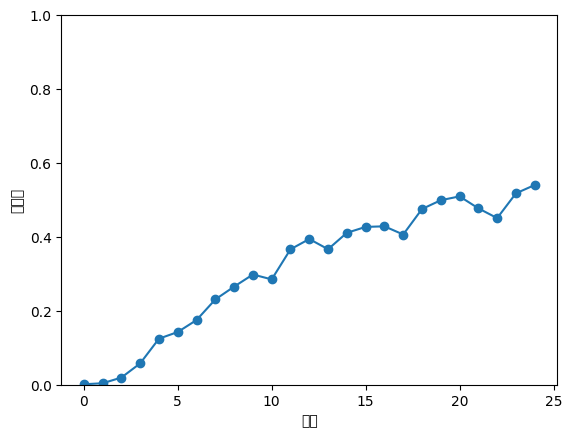

In [15]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq



# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()